# Image Style Transfer Using Convolutional Neural Networks #

Implemented By:
<table align="left">
  <td> <h5> <b> Roee Zamir </b> </h5> </td>
  <td>
    <a target="_blank" href="https://www.linkedin.com/in/roee-zamir-500121177/"><img src="https://cdn3.iconfinder.com/data/icons/free-social-icons/67/linkedin_circle_color-512.png" width="36"/></a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/roeez"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/roeez/NeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>  
</table>


**What?**</br>
This notebook contains an unofficial minimal simplified PyTorch Implementation of the paper [Image Style Transfer Using Convolutional Neural Networks](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html) (L. Gatys et al 2016), a cool method to transfer the style of one image to another. Given a *content image* and a *style image*, the result of this algorithm is an image composed of the *content image* and the style of the *style image*.

**How?**</br>
The authors found a way to extract the style/content of an image using a neural network that trained for image classification. The algorithm iteratively modifying the result image to match the style of the *style image* and the content of the *content image* simultaneously.

**Example**</br>
![result](https://raw.githubusercontent.com/roeez/NeuralStyleTransfer/master/example/fig1.png)

---




#Imports, defintions and utility functions.#

In [0]:
import torch
import numpy
import math
import torchvision
from google.colab.patches import cv2_imshow
import numpy as np
from torchvision import transforms as T
from PIL import Image
import IPython.display as display

class FeatureExtractor(torch.nn.Module):
    '''Get all the features extracted by the conv layers'''
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model
    
    def forward(self, x, layers):
        '''
        Return the features extracted by the chosen layers
        '''
        feats = []
        for i, l in enumerate(self.model.children()):
            x = l(x)
            if i in layers:
                feats.append(x)
        return feats

class Clip(object):
    '''Clip values transformation'''
    def __init__(self, min, max):
        self.min = min
        self.max = max

    def __call__(self, x):
        return x.clamp(self.min, self.max)

# ImageNet normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

postprocess = T.Compose([
    T.Normalize(mean=-mean/std, std=1/std),
    Clip(0,1),
    T.ToPILImage(),
])

def get_ranges(image):
    '''
    Returns the ranges [min_val, max_val] of the intensities of each channel
    of the input image (Used later for clipping of the modified image intensities)
    '''
    ranges = []
    for i in range(3):
        ranges.append([image[:,i,:].min().item(), image[:,i,:].max().item()])

    return ranges

def clip_intensities(image, ranges):
    for i in range(3):
        image[:,i,:,:] = image[:,i,:,:].clamp(*ranges[i])

    return image

def imshow(img):
  display.display(Image.fromarray(np.array(img)))

The paper uses a trained VGG19 model to extract features from the images.</br> `torchvision` includes an implemented and trained model.</br>
Colab allows you to use GPU, use it! (Runtime->Change runtime type->GPU)

In [0]:
# Dismiss the fully connected layers
model = next(torchvision.models.vgg19(pretrained=True).children())
model = FeatureExtractor(model)
model.eval()

# In this method, we don't change the model's weights. 
for param in model.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


# Download and open example images

--2020-06-05 09:19:08--  https://raw.githubusercontent.com/roeez/NeuralStyleTransfer/master/example/wis.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538055 (525K) [image/png]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 525.44K  --.-KB/s    in 0.04s   

2020-06-05 09:19:08 (13.2 MB/s) - ‘content.jpg’ saved [538055/538055]

--2020-06-05 09:19:10--  https://raw.githubusercontent.com/roeez/NeuralStyleTransfer/master/example/starry_night.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607848 (594K) [image/

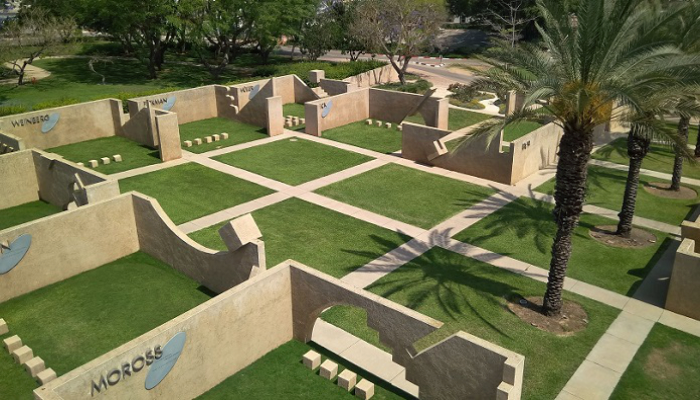

Style image:


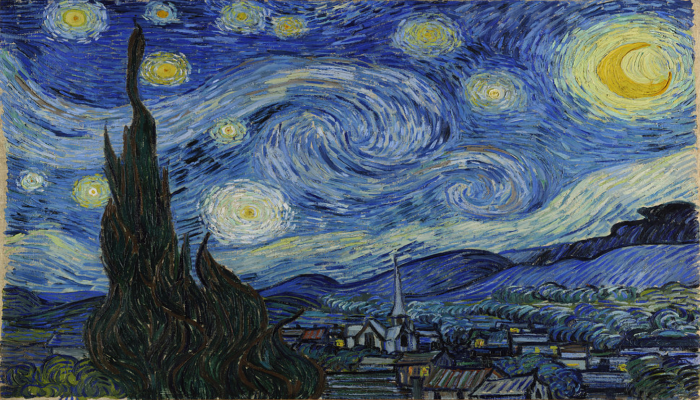

In [0]:
!wget https://raw.githubusercontent.com/roeez/NeuralStyleTransfer/master/example/wis.png -O content.jpg
!wget https://raw.githubusercontent.com/roeez/NeuralStyleTransfer/master/example/starry_night.png -O style.jpg

## Original paper images
# !wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/Tuebingen_Neckarfront.jpg -O content.jpg
# !wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/vangogh_starry_night.jpg -O style.jpg

content_img = preprocess(Image.open('/content/content.jpg'))[None, ...]
style_img = preprocess(Image.open('/content/style.jpg'))[None, ...]

if torch.cuda.is_available():
    content_img, style_img = content_img.cuda(), style_img.cuda()
print('Content image:')
imshow(postprocess(content_img[0].cpu()))
print('Style image:')
imshow(postprocess(style_img[0].cpu()))

# The Algorithm #

As mentioned, the idea is to extract the style from the *style image* - $I_s$ and the content from the *content image* - $I_c$ and then modify the result image $I_r$ to match both the style of $I_s$ and the content of $I_c$.

**The Style:**</br>
The authors observed in a [previous paper](https://arxiv.org/pdf/1505.07376.pdf) that textures of an image can be represented by the [Gram matrices](https://en.wikipedia.org/wiki/Gramian_matrix) of the features maps extracted by the network's layers (low-level layers for low-level textures and high-level for high-level textures).
The *style* of an image is a combination of low and high-level textures so it can be captured by the Gram matrices of features from all the levels of the network.

For a given set of vectors $V={\{v_1,\cdots,v_n}\}\subset\mathbb{R}^n $, denote by $M$ the matrix which $V$'s vectors are its columns. The **Gram matrix** is defined as $G:=M^TM$ so the entry $G_{ij}$ is the dot product of $v_i$ and $v_j$.

In our case, given the output of some layer $l$ denoted by $F$. Such that $F$ of size $c\times h\times w$. The vectors are the channels (by collapsing the spatial dimensions) so $G$ is of size $c\times c$.

To transfer the style of $I_s$ to $I_r$, we need to minimize the distance between their Gram matrices of different levels layers.


**The Content:**</br>
The content of some image is represented by the feature map outputted by some deep layer which encodes high-level information.
To transfer the content of $I_c$ to $I_r$, we need to minimize the distance between the output of the chosen layers for $I_c$ and $I_r$ as an input.

## Calculating the Gram matrix

In [0]:
def get_gram_matrices(mats):
    '''
    return the gram matrices of the of the tensors in the input list
    '''
    grams = []
    for mat in mats:
        mat = mat.squeeze() # Squeeze the batch dimension (the batch size is 1)
        c, h, w = mat.shape
        mat = mat.reshape((mat.size(0), -1)) # Flatten the spatial dimenstion

        # normalize by num of entries so the loss won't be affected 
        # from the size of the feature map
        grams.append(mat@mat.T/(h*w))
    
    return grams

## Choose the meaningful layers

In [0]:
style_layers = [1, 6, 11, 20, 29] # multiple level textures defines the style

content_layers = [22,] # one deep layer sufficient to extract the high level information

## Style tranfer

**initialization:**</br>
In the original paper initialized $I_r$ with random noise, Here I initialize $I_r$ with $I_c$ for faster convergence.</br>
**Optimizer:**</br>
The authors found that the second-order optimizer [***L-BFGS*** ](https://en.wikipedia.org/wiki/Limited-memory_BFGS) can help to get more appealing results.
Since the implementation of L-BFGS in pytorch reevaluates the module multiple times we need to perform the evaluation in a closure function that will be passed to the step method (The iterations will be done by the optimizer).**bold text** For more details see the [documentation](https://pytorch.org/docs/stable/optim.html#optimizer-step-closure).</br>
**Loss:**</br>
A weighted sum of the $\cal{L}_2^2$ distance between the content of $I_r$ and $I_c$ and the style of $I_r$ and $I_s$

In [0]:
def transferStyle(model, result_init, content_img, style_img, content_layers, style_layers, max_iter):
    content_objectives = model(content_img, content_layers)
    style_objectives = get_gram_matrices(model(style_img, style_layers))
    style_grams = (style_objectives)

    # Our optimization objective is the result image (not the network's weights)
    result_img = torch.autograd.Variable(result_init.clone(), requires_grad=True)

    criterion = torch.nn.MSELoss()
    optim = torch.optim.LBFGS([result_img,], max_iter=max_iter)

    def closure():
        optim.zero_grad()
        result_content = model(result_img, content_layers)
        result_style = get_gram_matrices(model(result_img, style_layers))
        result_style_grams = (result_style)
        style_loss = torch.stack([criterion(g1, g2) for g1, g2 in zip(result_style_grams, style_grams)]).sum()
        content_loss = torch.stack([criterion(c1, c2) for c1, c2 in zip(result_content, content_objectives)]).sum()

        loss = 1000*style_loss + 0*content_loss
        loss.backward()
        return loss
    optim.step(closure)

    return result_img

## Show me results!

For more artistic style and to save computational time, the style tranfer can be applied for multiple scale where In each iteration the previous is upscaled.


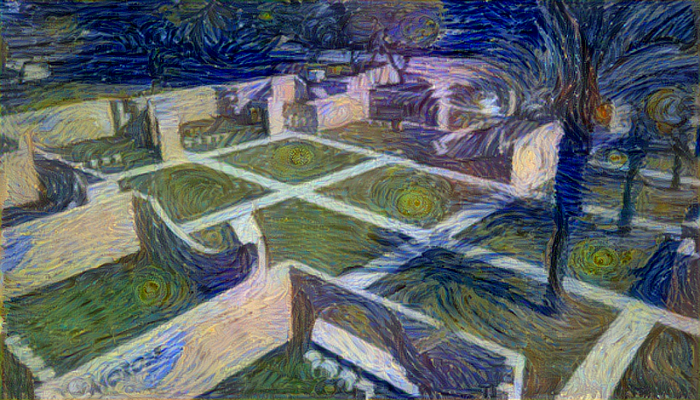

In [0]:
SCALE_FACTOR = 1.1

result_img = content_img.clone()
original_size = torch.tensor(result_img.shape[-2:])
for i in range(-4, 1, 2):
    content_resized = torch.nn.functional.interpolate(content_img, size=(original_size*(SCALE_FACTOR**i)).int().tolist(), mode='bicubic')
    result_img = torch.nn.functional.interpolate(result_img, size=(original_size*(SCALE_FACTOR**i)).int().tolist(), mode='bicubic')
    result_img = transferStyle(model, result_img, content_resized, style_img, content_layers, style_layers, 100//(5+i))
    display.clear_output(wait=True)
    imshow(postprocess(result_img[0].cpu()))

# What's next?


Feel free to try different content/style images, optimizers, losses and parameters as style/content loss weights, #iterations etc.





# Takeaways


*   **Content** can be represented by a feature map outputted by a deep layer.
*  Textures can be captured by Gram matrices of features maps (earlier layers for low-level textures and deeper layers for high-level textures)
*   **Style** (as a combination of textures) can be represented by Gram matrices of feature maps from all the levels of the network.







# Links </br>
*   [Original paper](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html)
*   [Official Pytorch implementation](https://github.com/leongatys/PytorchNeuralStyleTransfer)